### Parse files and save them to CSV files

- Open file by chunks
- Load parser
- Dask delayed to parallelize parsing
- Write data to CSV file (keep CSV filepath in an array for later use)
- Repeat until all file chunks are processed


In [1]:
import dask, os, pathlib, csv, re
import numpy as np
import statistics as st

In [2]:
def stats(data: list):
    return [st.mean(data), st.stdev(data)]

In [3]:
def align_channel(data: list):
    channel1 = data[0::2]
    channel2 = data[1::2]
    offset1 = st.mean(channel1)
    offset2 = st.mean(channel2)
    d = offset1 - offset2
    data[::2] = [x - d for x in channel1]
    data[1::2] = channel2
    data = np.asarray(data)
    return data

In [4]:
def standardize(data: list, stat: list):
    if stat[1] != 0:
        return (data - np.amin(data) + 1) / stat[1]
    else:
        return data

In [25]:
def barycenter(data: list):
    data_sum = np.sum(data)
    if data_sum != 0:
        return np.sum(data * np.arange(0,len(data))) / data_sum
    else:
        return -1

In [26]:
def parser(lines: list):
    pixels = []
    for line in lines:
        if line[0:2] == 'Fl':
            l = list(re.sub('=*#*>*,*','',line).split(' '))
            l = [x for x in l if x.strip()]
        elif line[0].isdigit():
            pixel_offset = l.index('is')
            data = align_channel(list(map(float, line.rstrip().split(' '))))
            stat = stats(data)
            std_data = standardize(data, stat)
            l = [float(l[l.index('event') + 1]),
                float(l[l.index('Spill') + 1]),
                float(l[l.index('Event-in-Spill') + 1]),
                float(l[pixel_offset + 1]),
                float(l[pixel_offset + 2]),
                float(barycenter(std_data))]
            l = np.concatenate((l, stat, data, std_data))
            pixels.append(l)
    return pixels 

In [31]:
filename = pathlib.Path('E:\gits\pphast-analyzer\data\ECAL2-Thr_60\ECAL2-Thr_60.txt')

head = ('run', 'spill', 'event', 'x', 'y', 'barycenter', 'mean', 'std')


with open(filename, 'r', 2000000) as readfile, open('output.csv','w', newline='') as result_file:
    writer = csv.writer(result_file, head, delimiter=',')
    result = dask.delayed(parser)(readfile.readlines())
    result.visualize()
    
    
    

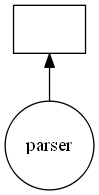

In [32]:
result.visualize()